In [1]:
select tx_source as Source, tx_target as Target, log10(tx_value) as Weight 
from `ethereum_bigquery.token_transfers`
where token = 'ZRX'

SyntaxError: invalid syntax (<ipython-input-1-bfb0040934df>, line 1)

ERC 20:

select * from `ethereum_bigquery.methods`
where id = '0xa9059cbb'

- id: '0x9059cbb
- name: transfer
- argumentType: address, uint256

https://www.4byte.directory/ used to ETH signature Database

以太坊虚拟机中的函数调用由与事务一起发送的数据的前四个字节指定。这些4字节的签名定义为函数签名的标准表示形式的Keccak哈希（SHA3）的前四个字节。该数据库还包含事件签名的映射。与函数签名不同，它们被定义为事件签名的标准形式的Keccak哈希（SHA3）的32字节。由于这是单向操作，因此无法从字节签名中得出功能或事件的人类可读表示。该数据库旨在允许将这些字节签名映射回其可读版本。

函数调用始终是4字节

14018	icapTransfer(bytes32,address,bytes32,uint256)	0x6042a760



-- SQL source from https://cloud.google.com/blog/products/data-analytics/introducing-six-new-cryptocurrencies-in-bigquery-public-datasets-and-how-to-analyze-them
WITH double_entry_book AS (
   -- debits
   SELECT
    array_to_string(inputs.addresses, ",") as address
   , inputs.type
   , -inputs.value as value
   FROM `bigquery-public-data.crypto_dogecoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT
    array_to_string(outputs.addresses, ",") as address
   , outputs.type
   , outputs.value as value
   FROM `bigquery-public-data.crypto_dogecoin.outputs` as outputs
)
SELECT
   address
,   type   
,   sum(value) as balance
FROM double_entry_book
GROUP BY 1,2
ORDER BY balance DESC
LIMIT 100

In [ ]:
36,711,936,291.78702011 DOGE
3671193629178702011


In [ ]:
-- SQL source from https://gist.github.com/allenday/1500cc268f24ae89b7adfc25c74967b0
WITH double_entry_book AS (
    -- debits
    SELECT
     array_to_string(inputs.addresses, ",") as address
    , inputs.type
    , -inputs.value as value
    , block_timestamp
    FROM `bigquery-public-data.crypto_dash.inputs` as inputs

    UNION ALL

    -- credits
    SELECT
     array_to_string(outputs.addresses, ",") as address
    , outputs.type
    , outputs.value as value
    , block_timestamp
    FROM `bigquery-public-data.crypto_dash.outputs` as outputs
)
,double_entry_book_by_date as (
    select
        date(block_timestamp) as date,
        address,
        sum(value / POWER(10,0)) as value
    from double_entry_book
    group by address, date
)
,daily_balances_with_gaps as (
    select
        address,
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, current_date()) over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array('2009-01-12', current_date())) as date
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)

select
    date,
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date asc

In [ ]:
BEGIN

CREATE TEMP FUNCTION
    PARSE_V1_CREATE_LOG(data STRING, topics ARRAY<STRING>)
    RETURNS STRUCT<`token` STRING, `exchange` STRING>
    LANGUAGE js AS """
    const parsedEvent = {
        "name": "NewExchange",
        "inputs": [{"type": "address", "name": "token", "indexed": true}, {"type": "address", "name": "exchange", "indexed": true}],
        "anonymous": false,
        "type": "event"
    }
    return abi.decodeEvent(parsedEvent, data, topics, false);
"""
    OPTIONS
  ( library="https://storage.googleapis.com/ethlab-183014.appspot.com/ethjs-abi.js" );


CREATE TABLE uniswap_v1_pairs
AS
(
    SELECT
        PARSE_V1_CREATE_LOG(logs.data, logs.topics).token as token,
        PARSE_V1_CREATE_LOG(logs.data, logs.topics).exchange as pair
    FROM `bigquery-public-data.crypto_ethereum.logs` AS logs
    WHERE address = '0xc0a47dfe034b400b47bdad5fecda2621de6c4d95'
    AND topics[SAFE_OFFSET(0)] = '0x9d42cb017eb05bd8944ab536a8b35bc68085931dd5f4356489801453923953f9'
);

END;

In [2]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth', 70)
client = bigquery.Client()


sql = """
select * from bigquery-public-data.crypto_ethereum.transactions where `hash` = '0x64334147bb418fbf8c772f545b7e8602c0601167733eec10312d729a982d6298'"""
res = client.query(sql).result()
rows = list(res)

contract = pd.DataFrame(columns=list(rows[0].keys()), data=[list(x.values()) for x in rows])
contract.info()

ModuleNotFoundError: No module named 'google'

In [3]:
[
  {
    "hash": "0x64334147bb418fbf8c772f545b7e8602c0601167733eec10312d729a982d6298",
    "nonce": "359",
    "transaction_index": "57",
    "from_address": "0x839b528b31643d1b4a8a5a00e55331035aa5dd6b",
    "to_address": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d",
    "value": "0",
    "gas": "283193",
    "gas_price": "60000000000",
    "input": "0x18cbafe500000000000000000000000000000000000000000000043c33c19375648000000000000000000000000000000000000000000000000000009cfa9beeecb1bc8400000000000000000000000000000000000000000000000000000000000000a0000000000000000000000000839b528b31643d1b4a8a5a00e55331035aa5dd6b0000000000000000000000000000000000000000000000000000000060841c490000000000000000000000000000000000000000000000000000000000000003000000000000000000000000c7283b66eb1eb5fb86327f08e1b5816b0720212b000000000000000000000000956f47f50a910163d8bf957cf5846d573e7f87ca000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2",
    "receipt_cumulative_gas_used": "4982125",
    "receipt_gas_used": "230804",
    "receipt_contract_address": null,
    "receipt_root": null,
    "receipt_status": "1",
    "block_timestamp": "2021-04-24 13:08:48 UTC",
    "block_number": "12303106",
    "block_hash": "0x91a79c7e09a1a9d42e143a676ce1f5049c30ae0a805d25495fb12a5e3f85c6d2"
  }
]

NameError: name 'null' is not defined

In [ ]:
Function: swapExactTokensForETH(uint256 amountIn, uint256 amountOutMin, address[] path, address to, uint256 deadline)

MethodID: 0x18cbafe5
[0]:  00000000000000000000000000000000000000000000043c33c1937564800000
[1]:  0000000000000000000000000000000000000000000000009cfa9beeecb1bc84
[2]:  00000000000000000000000000000000000000000000000000000000000000a0
[3]:  000000000000000000000000839b528b31643d1b4a8a5a00e55331035aa5dd6b
[4]:  0000000000000000000000000000000000000000000000000000000060841c49
[5]:  0000000000000000000000000000000000000000000000000000000000000003
[6]:  000000000000000000000000c7283b66eb1eb5fb86327f08e1b5816b0720212b
[7]:  000000000000000000000000956f47f50a910163d8bf957cf5846d573e7f87ca
[8]:  000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2

In [3]:
amountIn = "00000000000000000000000000000000000000000000043c33c1937564800000"
print("amountIn:", int(amountIn,16))
amountOutMin = "0000000000000000000000000000000000000000000000009cfa9beeecb1bc84"
print("amountOutMin:", int(amountOutMin,16))
address_1 = "00000000000000000000000000000000000000000000000000000000000000a0"
str(address_1)

amountIn: 20000000000000000000000
amountOutMin: 11311524864570014852


'00000000000000000000000000000000000000000000000000000000000000a0'

In [ ]:
#	Name	Type	Data
0	amountIn	uint256	20000000000000000000000
1	amountOutMin	uint256	11311524864570014852
2	path	address[]	
0xc7283b66Eb1EB5FB86327f08e1B5816b0720212B
0x956F47F50A910163D8BF957Cf5846D573E7f87CA
0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2
3	to	address	0x839b528B31643d1b4A8A5a00E55331035AA5dd6b
4	deadline	uint256	1619270729

In [ ]:
select * from `blockchain-etl.ethereum_uniswap.UniswapV2Pair_event_Swap` where transaction_hash = '0x64334147bb418fbf8c772f545b7e8602c0601167733eec10312d729a982d6298'

In [ ]:
[
  {
    "block_timestamp": "2021-04-24 13:08:48 UTC",
    "block_number": "12303106",
    "transaction_hash": "0x64334147bb418fbf8c772f545b7e8602c0601167733eec10312d729a982d6298",
    "log_index": "94",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d",
    "amount0In": "30216122888048049082621",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "11368082488892864927",
    "to": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d"
  },
  {
    "block_timestamp": "2021-04-24 13:08:48 UTC",
    "block_number": "12303106",
    "transaction_hash": "0x64334147bb418fbf8c772f545b7e8602c0601167733eec10312d729a982d6298",
    "log_index": "91",
    "contract_address": "0x9928e4046d7c6513326ccea028cd3e7a91c7590a",
    "sender": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d",
    "amount0In": "0",
    "amount1In": "20000000000000000000000",
    "amount0Out": "30216122888048049082621",
    "amount1Out": "0",
    "to": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878"
  }

In [ ]:
select * from `bigquery-public-data.crypto_ethereum.transactions` where contract_address = '0x94b0a3d511b6ecdb17ebf877278ab030acb0a878' limit 10  

In [ ]:
select * from `blockchain-etl.ethereum_uniswap.UniswapV2Pair_event_Swap` where contract_address = '0x94b0a3d511b6ecdb17ebf877278ab030acb0a878'

In [ ]:
select * from `blockchain-etl.ethereum_uniswap.UniswapV2Pair_event_Swap` where contract_address = '0x94b0a3d511b6ecdb17ebf877278ab030acb0a878' order by block_timestamp desc limit 10

In [ ]:
[
  {
    "block_timestamp": "2021-04-24 14:11:19 UTC",
    "block_number": "12303401",
    "transaction_hash": "0xb96690114056c8d40db384b5af70104129350b5e25024109ab8e59e0d65b52e4",
    "log_index": "318",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x9271d303b57c204636c38df0ed339b18bf98f909",
    "amount0In": "815107112798365021308",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "306651405071186941",
    "to": "0x9271d303b57c204636c38df0ed339b18bf98f909"
  },
  {
    "block_timestamp": "2021-04-24 14:10:09 UTC",
    "block_number": "12303397",
    "transaction_hash": "0xcb9d1e024f9e2e623a72c799250dfc0cd636e32850289940355ca94c393b8ba3",
    "log_index": "170",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d",
    "amount0In": "9523441808118607236722",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "3582843277703350613",
    "to": "0xc730ef0f4973da9cc0ab8ab291890d3e77f58f79"
  },
  {
    "block_timestamp": "2021-04-24 14:02:09 UTC",
    "block_number": "12303353",
    "transaction_hash": "0x824a8f5515585b80ed1efcdf84db7d190b6bfebe276784e039af7bdb59d1eff7",
    "log_index": "378",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d",
    "amount0In": "1000000000000000000000",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "376216238897056162",
    "to": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d"
  },
  {
    "block_timestamp": "2021-04-24 14:00:20 UTC",
    "block_number": "12303337",
    "transaction_hash": "0x9c3ef97874c02f7dc0eb668170485e918d2ecd065be4bd06fcce82b2f263721f",
    "log_index": "236",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x9271d303b57c204636c38df0ed339b18bf98f909",
    "amount0In": "1000000000000000000000",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "376216841929046955",
    "to": "0x9271d303b57c204636c38df0ed339b18bf98f909"
  },
  {
    "block_timestamp": "2021-04-24 13:56:51 UTC",
    "block_number": "12303320",
    "transaction_hash": "0x68a8043320b876ddc7f1fd8a849ce6424d56b48768270ea5138571cd96e0bb50",
    "log_index": "297",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d",
    "amount0In": "0",
    "amount1In": "8883878852828014627",
    "amount0Out": "23472674150372520685174",
    "amount1Out": "0",
    "to": "0xee2826453a4fd5afeb7ceffeef3ffa2320081268"
  },
  {
    "block_timestamp": "2021-04-24 13:49:20 UTC",
    "block_number": "12303296",
    "transaction_hash": "0x0759627c16bd787fc7f3226f5be178720b5e343c03d792dc2394c29622320887",
    "log_index": "213",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0xdef1c0ded9bec7f1a1670819833240f027b25eff",
    "amount0In": "0",
    "amount1In": "32711250000000000",
    "amount0Out": "86430155611084290781",
    "amount1Out": "0",
    "to": "0x74de5d4fcbf63e00296fd95d33236b9794016631"
  },
  {
    "block_timestamp": "2021-04-24 13:44:51 UTC",
    "block_number": "12303276",
    "transaction_hash": "0x0c4b742ad0717f1ae741f142f9697b6b522becb11b135578381eab54de0af6f3",
    "log_index": "190",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x9271d303b57c204636c38df0ed339b18bf98f909",
    "amount0In": "10000000000000000000",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "3762028967401359",
    "to": "0x9271d303b57c204636c38df0ed339b18bf98f909"
  },
  {
    "block_timestamp": "2021-04-24 13:41:50 UTC",
    "block_number": "12303257",
    "transaction_hash": "0x040fdfe18f3a3cd8c6256bdbb297e9bf40dd3510b8b35774eccdfd78544801de",
    "log_index": "55",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x9271d303b57c204636c38df0ed339b18bf98f909",
    "amount0In": "0",
    "amount1In": "100000000000000000",
    "amount0Out": "264221570885143482860",
    "amount1Out": "0",
    "to": "0x59be9da8ae260cc45dbca5df35ea6bd16d0ed96f"
  },
  {
    "block_timestamp": "2021-04-24 13:32:40 UTC",
    "block_number": "12303222",
    "transaction_hash": "0x04fc0089d8e817082ff24d4f1a3de67fb919332830a991e0eb8bf8a815dc2260",
    "log_index": "307",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d",
    "amount0In": "815107112798365021308",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "306645729801236369",
    "to": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d"
  },
  {
    "block_timestamp": "2021-04-24 13:17:41 UTC",
    "block_number": "12303152",
    "transaction_hash": "0x40546905e9cebd1366894e7ca83f8527d3d7f134b9c2476d43d75705c70a5b13",
    "log_index": "336",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0xdef1c0ded9bec7f1a1670819833240f027b25eff",
    "amount0In": "0",
    "amount1In": "49562500000000000",
    "amount0Out": "130954686555396380779",
    "amount1Out": "0",
    "to": "0x74de5d4fcbf63e00296fd95d33236b9794016631"
  }
]


In [6]:
sql = """
select * from `blockchain-etl.ethereum_uniswap.UniswapV2Pair_event_Swap` where contract_address = '0x94b0a3d511b6ecdb17ebf877278ab030acb0a878' order by block_timestamp desc limit 10
"""

from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth', 70)

client = bigquery.Client()
res = client.query(sql).result()
rows = list(res)
print(rows)
contract = pd.DataFrame(columns=list(rows[0].keys()), data=[list(x.values()) for x in rows])
contract.info()

ModuleNotFoundError: No module named 'google'

In [13]:
delta = 5.040172021751833297 - 5
price = 2216.56
gas_price = 0.000000061875000117
gas_used = 268411
profit = delta * price
cost = gas_price * gas_used
print(profit, cost) 

89.04369653424367 0.016607930656404087


In [21]:
data = [
  {
    "block_timestamp": "2021-04-25 00:13:17 UTC",
    "block_number": "12306135",
    "transaction_hash": "0xdef25bf72ee1d7b781bfbf2725ab9a95ab74d4b8eac35ebd9a11affb423dd4e4",
    "log_index": "148",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0xdef1c0ded9bec7f1a1670819833240f027b25eff",
    "amount0In": "208045401728282976625",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "78430934565466311",
    "to": "0xdef1c0ded9bec7f1a1670819833240f027b25eff"
  },
  {
    "block_timestamp": "2021-04-24 23:57:12 UTC",
    "block_number": "12306067",
    "transaction_hash": "0xd9dd57b05793b34b2428bbaed419226ece93e99408c30a76f512daa2f2de9f93",
    "log_index": "65",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66",
    "amount0In": "2564948555991171536995",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "966960859492018550",
    "to": "0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66"
  },
  {
    "block_timestamp": "2021-04-24 23:54:51 UTC",
    "block_number": "12306059",
    "transaction_hash": "0xb16745d38b482008e324b05aea89c56090e645075f6de84326b0e18a5fd2e52a",
    "log_index": "95",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x0000000089341e263b85d84a0eea39f47c37a9d2",
    "amount0In": "0",
    "amount1In": "7100000000000000000",
    "amount0Out": "18720786439903454830322",
    "amount1Out": "0",
    "to": "0x765be0ee8e1857a8d7e906afa07cf0d2cf36ff59"
  },
  {
    "block_timestamp": "2021-04-24 23:53:06 UTC",
    "block_number": "12306055",
    "transaction_hash": "0x9dbd4dcbeaaab323a56f5e9b0ad442fd05f81a7e20798646c0e0fc14c911a7c0",
    "log_index": "318",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x0000000089341e263b85d84a0eea39f47c37a9d2",
    "amount0In": "0",
    "amount1In": "5000000000000000000",
    "amount0Out": "13183990797551716490953",
    "amount1Out": "0",
    "to": "0x40c6bc1db179a5c3d464cac557ab890825c638f3"
  },
  {
    "block_timestamp": "2021-04-24 23:51:09 UTC",
    "block_number": "12306045",
    "transaction_hash": "0xfb7134add41967c1565b42b052e148453220b7965acfeae4d8b26be8e83f7655",
    "log_index": "219",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x000000000075a43abafc7c8ac407c6ce74f3cc28",
    "amount0In": "0",
    "amount1In": "5683171352509415424",
    "amount0Out": "14985715470109711587694",
    "amount1Out": "0",
    "to": "0x765be0ee8e1857a8d7e906afa07cf0d2cf36ff59"
  },
  {
    "block_timestamp": "2021-04-24 23:46:29 UTC",
    "block_number": "12306025",
    "transaction_hash": "0xbe51f337c2e02a09f0eb9a0f6131dac0e0b120d4504f31ed1fc1445a1b0be44e",
    "log_index": "220",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x9271d303b57c204636c38df0ed339b18bf98f909",
    "amount0In": "101888389099795627663",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "38408123304756316",
    "to": "0x9271d303b57c204636c38df0ed339b18bf98f909"
  },
  {
    "block_timestamp": "2021-04-24 23:35:35 UTC",
    "block_number": "12305970",
    "transaction_hash": "0x13140a49120bcf907d4b1e7a1b0a3e857e67efc7c320f9755be3ccb890980030",
    "log_index": "96",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0xdef1c0ded9bec7f1a1670819833240f027b25eff",
    "amount0In": "0",
    "amount1In": "1982500000000000000",
    "amount0Out": "5227654962742102081585",
    "amount1Out": "0",
    "to": "0x74de5d4fcbf63e00296fd95d33236b9794016631"
  },
  {
    "block_timestamp": "2021-04-24 23:31:34 UTC",
    "block_number": "12305945",
    "transaction_hash": "0x844add7ba4da21ba1c8565e2fd81ad7f056c574bf16410103dc98644fedc93b7",
    "log_index": "270",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x9271d303b57c204636c38df0ed339b18bf98f909",
    "amount0In": "3056651672993868829905",
    "amount1In": "0",
    "amount0Out": "0",
    "amount1Out": "1152236929320734230",
    "to": "0x9271d303b57c204636c38df0ed339b18bf98f909"
  },
  {
    "block_timestamp": "2021-04-24 23:27:06 UTC",
    "block_number": "12305920",
    "transaction_hash": "0xb2335044ff2feaa4712a3844cbf9aa926b965c525972248ee3266fb8f9047342",
    "log_index": "261",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d",
    "amount0In": "0",
    "amount1In": "60000000000000000",
    "amount0Out": "158213930330425018224",
    "amount1Out": "0",
    "to": "0xbf88afd960ed56d88734c3f25c4acf8155639653"
  },
  {
    "block_timestamp": "2021-04-24 23:26:54 UTC",
    "block_number": "12305919",
    "transaction_hash": "0x363a43c991b87a6f86ddb6002c7b8319682d7a99472e8397058144d55223f632",
    "log_index": "375",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d",
    "amount0In": "0",
    "amount1In": "2184373722227144865",
    "amount0Out": "5760000000000000000000",
    "amount1Out": "0",
    "to": "0x2b5d4b3c2cedcc63b7765f377d2929ee1f99049e"
  }
]
import pandas as pd
import numpy as np

pd.DataFrame(data).set_index('transaction_hash')


,block_timestamp,block_number,log_index,contract_address,sender,amount0In,amount1In,amount0Out,amount1Out,to
transaction_hash,,,,,,,,,,
0xdef25bf72ee1d7b781bfbf2725ab9a95ab74d4b8eac35ebd9a11affb423dd4e4,2021-04-25 00:13:17 UTC,12306135,148,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0xdef1c0ded9bec7f1a1670819833240f027b25eff,208045401728282976625,0,0,78430934565466311,0xdef1c0ded9bec7f1a1670819833240f027b25eff
0xd9dd57b05793b34b2428bbaed419226ece93e99408c30a76f512daa2f2de9f93,2021-04-24 23:57:12 UTC,12306067,65,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66,2564948555991171536995,0,0,966960859492018550,0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66
0xb16745d38b482008e324b05aea89c56090e645075f6de84326b0e18a5fd2e52a,2021-04-24 23:54:51 UTC,12306059,95,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x0000000089341e263b85d84a0eea39f47c37a9d2,0,7100000000000000000,18720786439903454830322,0,0x765be0ee8e1857a8d7e906afa07cf0d2cf36ff59
0x9dbd4dcbeaaab323a56f5e9b0ad442fd05f81a7e20798646c0e0fc14c911a7c0,2021-04-24 23:53:06 UTC,12306055,318,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x0000000089341e263b85d84a0eea39f47c37a9d2,0,5000000000000000000,13183990797551716490953,0,0x40c6bc1db179a5c3d464cac557ab890825c638f3
0xfb7134add41967c1565b42b052e148453220b7965acfeae4d8b26be8e83f7655,2021-04-24 23:51:09 UTC,12306045,219,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x000000000075a43abafc7c8ac407c6ce74f3cc28,0,5683171352509415424,14985715470109711587694,0,0x765be0ee8e1857a8d7e906afa07cf0d2cf36ff59
0xbe51f337c2e02a09f0eb9a0f6131dac0e0b120d4504f31ed1fc1445a1b0be44e,2021-04-24 23:46:29 UTC,12306025,220,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x9271d303b57c204636c38df0ed339b18bf98f909,101888389099795627663,0,0,38408123304756316,0x9271d303b57c204636c38df0ed339b18bf98f909
0x13140a49120bcf907d4b1e7a1b0a3e857e67efc7c320f9755be3ccb890980030,2021-04-24 23:35:35 UTC,12305970,96,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0,1982500000000000000,5227654962742102081585,0,0x74de5d4fcbf63e00296fd95d33236b9794016631
0x844add7ba4da21ba1c8565e2fd81ad7f056c574bf16410103dc98644fedc93b7,2021-04-24 23:31:34 UTC,12305945,270,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x9271d303b57c204636c38df0ed339b18bf98f909,3056651672993868829905,0,0,1152236929320734230,0x9271d303b57c204636c38df0ed339b18bf98f909
0xb2335044ff2feaa4712a3844cbf9aa926b965c525972248ee3266fb8f9047342,2021-04-24 23:27:06 UTC,12305920,261,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0,60000000000000000,158213930330425018224,0,0xbf88afd960ed56d88734c3f25c4acf8155639653


In [ ]:
https://etherscan.io/tx/0x9dbd4dcbeaaab323a56f5e9b0ad442fd05f81a7e20798646c0e0fc14c911a7c0/

In [ ]:
{
    "block_timestamp": "2021-04-24 23:53:06 UTC",
    "block_number": "12306055",
    "transaction_hash": "0x9dbd4dcbeaaab323a56f5e9b0ad442fd05f81a7e20798646c0e0fc14c911a7c0",
    "log_index": "318",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x0000000089341e263b85d84a0eea39f47c37a9d2",
    "amount0In": "0",
    "amount1In": "5000000000000000000",
    "amount0Out": "13183990797551716490953",
    "amount1Out": "0",
    "to": "0x40c6bc1db179a5c3d464cac557ab890825c638f3"
  },

In [15]:
import pandas as pd
import numpy as np

file_name = r'C:\Users\qli32\Downloads\FEI_ETH.csv'

fei_eth_data = pd.read_csv(file_name, index_col=['transaction_hash'])
fei_eth_data.head()
pd.to_datetime(fei_eth_data['block_timestamp'], format="%Y-%m-%d %H:%M:%S UTC")
fei_eth_data.sort_values(by='block_timestamp',ascending=False)

,block_timestamp,block_number,log_index,contract_address,sender,amount0In,amount1In,amount0Out,amount1Out,to
transaction_hash,,,,,,,,,,
0xeaa7a0f68f537bd61d16ab21cb380f14e3ce5ca26fa9cc875f29b102ebc0fc57,2021-04-25 00:19:47 UTC,12306160,93,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,259609323537855313362,0,0,97869955595806826,0x7a250d5630b4cf539739df2c5dacb4c659f2488d
0xdef25bf72ee1d7b781bfbf2725ab9a95ab74d4b8eac35ebd9a11affb423dd4e4,2021-04-25 00:13:17 UTC,12306135,148,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0xdef1c0ded9bec7f1a1670819833240f027b25eff,208045401728282976625,0,0,78430934565466311,0xdef1c0ded9bec7f1a1670819833240f027b25eff
0xd9dd57b05793b34b2428bbaed419226ece93e99408c30a76f512daa2f2de9f93,2021-04-24 23:57:12 UTC,12306067,65,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66,2564948555991171536995,0,0,966960859492018550,0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66
0xb16745d38b482008e324b05aea89c56090e645075f6de84326b0e18a5fd2e52a,2021-04-24 23:54:51 UTC,12306059,95,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x0000000089341e263b85d84a0eea39f47c37a9d2,0,7100000000000000000,18720786439903454830322,0,0x765be0ee8e1857a8d7e906afa07cf0d2cf36ff59
0x9dbd4dcbeaaab323a56f5e9b0ad442fd05f81a7e20798646c0e0fc14c911a7c0,2021-04-24 23:53:06 UTC,12306055,318,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x0000000089341e263b85d84a0eea39f47c37a9d2,0,5000000000000000000,13183990797551716490953,0,0x40c6bc1db179a5c3d464cac557ab890825c638f3
...,...,...,...,...,...,...,...,...,...,...
0x3dd3e1b61fbe1dcfc3c5a60ceed774b914704df32ba7192a1640993e01ffdc7f,2021-04-03 19:01:19 UTC,12168373,150,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0,200000000000000000,417609981201534727902,0,0xc3ec7b35180768cf73d2f5ff9ec82485106d5d7c
0x2fd4a218b8733ebe9e3ebf950e3aae1e0981b3b336deecdde6b7c540dfffd1b6,2021-04-03 19:01:19 UTC,12168373,7,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,990583523891306325664710,0,0,471915956463199172955,0x7a250d5630b4cf539739df2c5dacb4c659f2488d
0x3347f819f2bf7e7c54f59b97fecb84399ff479f93d2fa90f653074c2bc595a04,2021-04-03 19:00:36 UTC,12168369,38,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,1945270754276974176331338,0,0,928783241911505597655,0x7a250d5630b4cf539739df2c5dacb4c659f2488d


In [105]:
fei_eth_data['amount0In'] = fei_eth_data['amount0In'].astype(np.float64) / pow(10,18)
fei_eth_data['amount0Out'] = fei_eth_data['amount0Out'].astype(np.float64) / pow(10,18)
fei_eth_data['amount1In'] = fei_eth_data['amount1In'].astype(np.float64) / pow(10,18)
fei_eth_data['amount1Out'] = fei_eth_data['amount1Out'].astype(np.float64) / pow(10,18)
fei_eth_data['actual_price_a2b'] = fei_eth_data['amount1Out'] / fei_eth_data['amount0In']
fei_eth_data['actual_price_b2a'] = fei_eth_data['amount0Out'] / fei_eth_data['amount1In']

In [106]:
fei_eth_data.groupby('sender').size()

sender
0x0000000000000eb4ec62758aae93400b3e5f7f18      56
0x0000000000007f150bd6f54c40a34d7c3d5e9f56       2
0x0000000000438f975cbde76d5fdd1aa76be46577      16
0x000000000075a43abafc7c8ac407c6ce74f3cc28     218
0x000000005804b22091aa9830e50459a15e7c9241       2
0x0000000089341e263b85d84a0eea39f47c37a9d2      24
0x0000000094acb89a43eac2fbb3a07973efc2435c       4
0x00000000fea1fab3ce021f3bedd21a94d0ba190c      22
0x043957f7554275b90c5178872fae851dcfc1089d      10
0x09911f043516d1881b0eebe2be03da48b86717aa       1
0x09ccaa9943e5fbe223e41cb50cb60262ff4973a1       2
0x0aa3e7a66c470ee6dc4f2ba2cead3b32200a8af5       9
0x11111112542d85b3ef69ae05771c2dccff4faa26     100
0x16e31d39d95d755aba1c28675dc788ca6d34097c       2
0x197e604f40f318a7098ed88df7f2cc0a05f44c2e       1
0x1bd435f3c054b6e901b7b108a0ab7617c808677b       5
0x3700006fbcde59a8b3af2c134d00e9530000e379       2
0x3c653f8fed7b0f51c1cadf46e7c798b476ca8d3a      27
0x4e88662741eb3c7af27e9f30598216a2df4f44fa       2
0x595f2a9f5f4db2f858ea56

In [113]:
fei_eth_data['actual_price_a2b'].plot(figsize=(16,9))
# fei_eth_data['actual_price_b2a'].plot(figsize=(16,9))

NameError: name 'fei_eth_data' is not defined

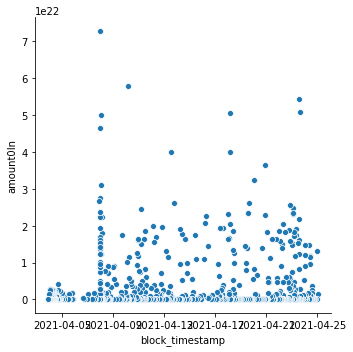

In [112]:
sns.relplot(x='block_timestamp', y='amount0In',data=fei_usdc_data)

In [134]:
fei_eth_data.loc['0x9dbd4dcbeaaab323a56f5e9b0ad442fd05f81a7e20798646c0e0fc14c911a7c0']

block_timestamp                        2021-04-24 23:53:06 UTC
block_number                                          12306055
log_index                                                  318
contract_address    0x94b0a3d511b6ecdb17ebf877278ab030acb0a878
sender              0x0000000089341e263b85d84a0eea39f47c37a9d2
amount0In                                                    0
amount1In                                                    5
amount0Out                                               13184
amount1Out                                                   0
to                  0x40c6bc1db179a5c3d464cac557ab890825c638f3
actual_price_a2b                                           NaN
actual_price_b2a                                        2636.8
Name: 0x9dbd4dcbeaaab323a56f5e9b0ad442fd05f81a7e20798646c0e0fc14c911a7c0, dtype: object

In [126]:
import pandas as pd
import numpy as np



file_name = r'C:\Users\qli32\Downloads\USDC_ETH.csv'

usdc_eth_data = pd.read_csv(file_name, index_col=['transaction_hash'], parse_dates=True)


usdc_eth_data.info()



<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 0x91956a9e3be88f31be61458881b86fe836cc1a780a20de71b6c2f55eaf2c8baa to 0x85876ac528ebd20c504894e33cf7d468863ce799b31e679bd6cdfbe06e71a627
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   block_timestamp   16000 non-null  object
 1   block_number      16000 non-null  int64 
 2   log_index         16000 non-null  int64 
 3   contract_address  16000 non-null  object
 4   sender            16000 non-null  object
 5   amount0In         16000 non-null  int64 
 6   amount1In         16000 non-null  object
 7   amount0Out        16000 non-null  int64 
 8   amount1Out        16000 non-null  object
 9   to                16000 non-null  object
dtypes: int64(4), object(6)
memory usage: 1.3+ MB


In [129]:
usdc_eth_data['amount0In'] = usdc_eth_data['amount0In'].astype(np.float64) / pow(10,6)
usdc_eth_data['amount0Out'] = usdc_eth_data['amount0Out'].astype(np.float64) / pow(10,6)
usdc_eth_data['amount1In'] = usdc_eth_data['amount1In'].astype(np.float64) / pow(10,18)
usdc_eth_data['amount1Out'] = usdc_eth_data['amount1Out'].astype(np.float64) / pow(10,18)
usdc_eth_data['actual_price_a2b'] = usdc_eth_data['amount1Out'] / usdc_eth_data['amount0In']
usdc_eth_data['actual_price_b2a'] = usdc_eth_data['amount0Out'] / usdc_eth_data['amount1In']


In [130]:
usdc_eth_data.loc['0x91956a9e3be88f31be61458881b86fe836cc1a780a20de71b6c2f55eaf2c8baa']

block_timestamp                        2021-04-25 01:44:44 UTC
block_number                                          12306517
log_index                                                   25
contract_address    0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc
sender              0x7a250d5630b4cf539739df2c5dacb4c659f2488d
amount0In                                                    0
amount1In                                             0.990843
amount0Out                                             2210.59
amount1Out                                                   0
to                  0x36314738fce9aca7944d06d18a5fafc7925f26ff
actual_price_a2b                                           NaN
actual_price_b2a                                       2231.02
Name: 0x91956a9e3be88f31be61458881b86fe836cc1a780a20de71b6c2f55eaf2c8baa, dtype: object

In [132]:
usdc_eth_data.loc[usdc_eth_data['to']=='0x0000000089341e263b85d84a0eea39f47c37a9d2'].loc['0x9dbd4dcbeaaab323a56f5e9b0ad442fd05f81a7e20798646c0e0fc14c911a7c0']

block_timestamp                        2021-04-24 23:53:06 UTC
block_number                                          12306055
log_index                                                  324
contract_address    0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc
sender              0x0000000089341e263b85d84a0eea39f47c37a9d2
amount0In                                              11189.7
amount1In                                                    0
amount0Out                                                   0
amount1Out                                             5.04017
to                  0x0000000089341e263b85d84a0eea39f47c37a9d2
actual_price_a2b                                    0.00045043
actual_price_b2a                                           NaN
Name: 0x9dbd4dcbeaaab323a56f5e9b0ad442fd05f81a7e20798646c0e0fc14c911a7c0, dtype: object

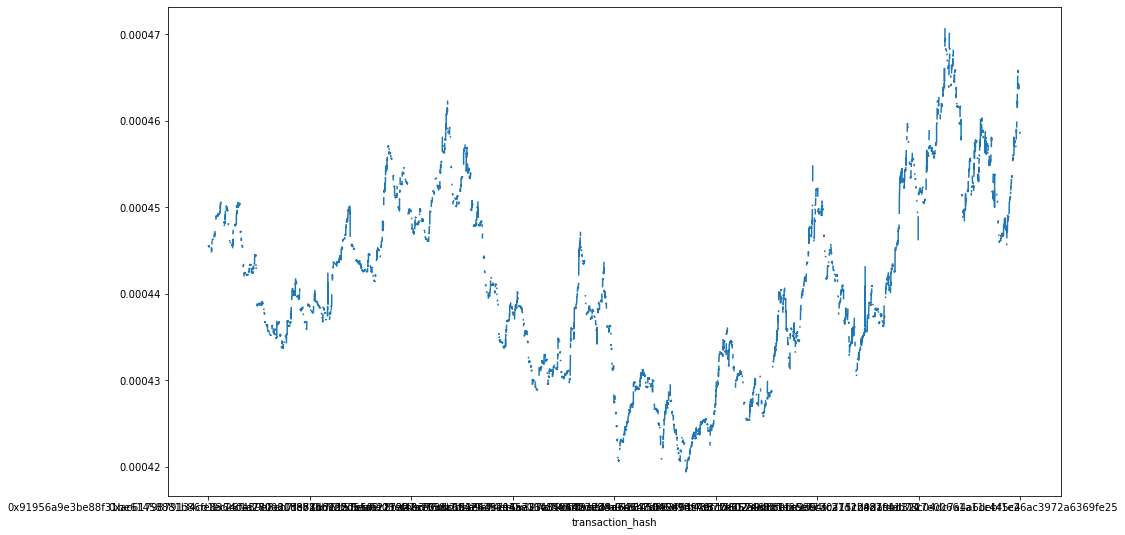

In [131]:
usdc_eth_data.actual_price_a2b.plot(figsize=(16,9))

In [2]:
sql  = """
select * from `blockchain-etl.ethereum_uniswap.UniswapV2Pair_event_Swap` where contract_address = '0x40c6bc1db179a5c3d464cac557ab890825c638f3' order by block_timestamp desc 
"""
import pandas as pd
import numpy as np



file_name = r'C:\Users\qli32\Downloads\FEI_USDC.csv'

fei_usdc_data = pd.read_csv(file_name, index_col=['transaction_hash'], parse_dates=True)
fei_usdc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692 entries, 0xa6928fda030ca120f99b67ee786c69c61a1632e9a73e8036c6a2a71d730f0531 to 0x8e5e9d43349c832532789e79dca7da662bc2a72b813eae253abe9a56859d156a
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   block_timestamp   692 non-null    object 
 1   block_number      692 non-null    int64  
 2   log_index         692 non-null    int64  
 3   contract_address  692 non-null    object 
 4   sender            692 non-null    object 
 5   amount0In         692 non-null    float64
 6   amount1In         692 non-null    int64  
 7   amount0Out        692 non-null    float64
 8   amount1Out        692 non-null    int64  
 9   to                692 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 59.5+ KB


In [3]:
fei_usdc_data.loc[(fei_usdc_data['to']=='0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc') & (fei_usdc_data['log_index'] == 171)]

,block_timestamp,block_number,log_index,contract_address,sender,amount0In,amount1In,amount0Out,amount1Out,to
transaction_hash,,,,,,,,,,
0x2ad7d0e4185d98c456789f4d4efdf92feb899b5b9e5fa61f8393689287720896,2021-04-25 00:37:15 UTC,12306228,171,0x40c6bc1db179a5c3d464cac557ab890825c638f3,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,1.456250e+20,0,0.0,122899784,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc
0x1148a59528896b32abb991a4766bf7eb39ac270643b737fecc336de78b4eaca7,2021-04-23 13:05:43 UTC,12296590,171,0x40c6bc1db179a5c3d464cac557ab890825c638f3,0x000000000075a43abafc7c8ac407c6ce74f3cc28,1.538450e+22,0,0.0,12776217736,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc


In [4]:
166361390.71*0.000009

1497.2525163900002

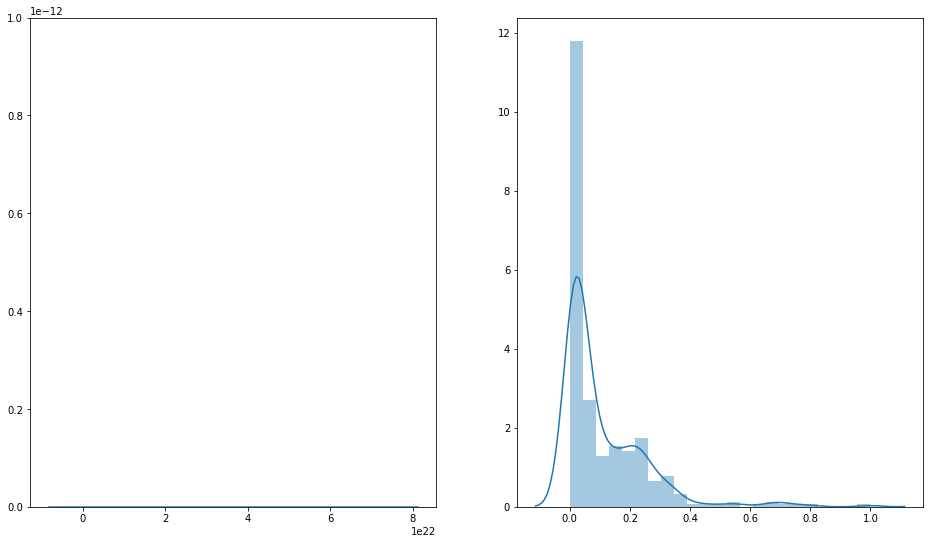

In [23]:
# 倍增处理
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt


original_data = pd.DataFrame(fei_usdc_data.loc[fei_usdc_data['amount0In'] > 0]['amount0In'])

scaled_data = minmax_scaling(original_data, columns=['amount0In'])
# print(original_data)

fig, ax = plt.subplots(1,2,figsize=(16,9))

sns.distplot(original_data, ax=ax[0])
sns.distplot(scaled_data, ax=ax[1])

72880.2 0.091
29.611644132160638 -2.0076120432170597


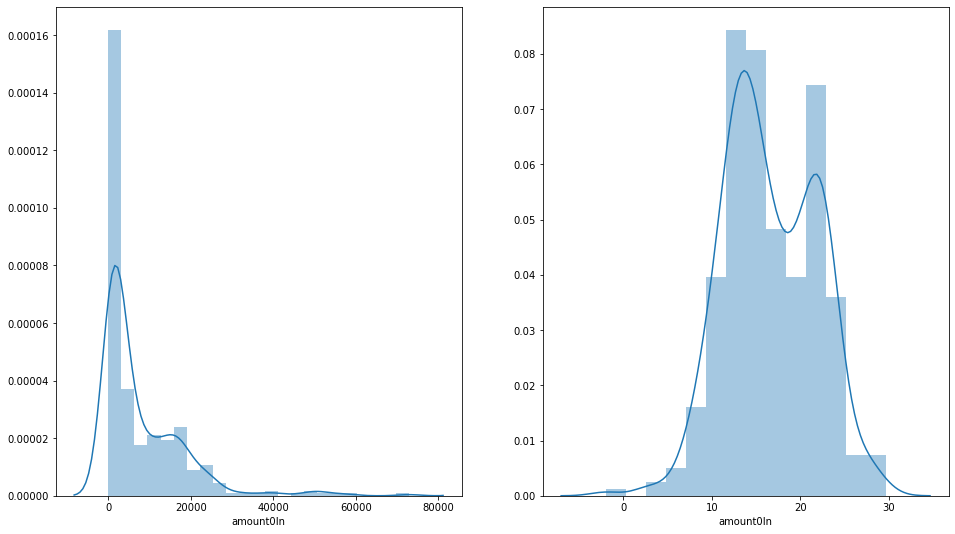

In [42]:
# 标准化处理
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

original_data = fei_usdc_data.loc[fei_usdc_data['amount0In'] > 0, 'amount0In'].map(lambda x: round(x/pow(10,18),3))
print(original_data.max(), original_data.min())
normalized_data = pd.Series(stats.boxcox(original_data)[0], name='amount0In', index=original_data.index)
print(normalized_data.max(), normalized_data.min())

fig, ax = plt.subplots(1,2,figsize=(16,9))
sns.distplot(original_data, ax=ax[0])
sns.distplot(normalized_data,ax=ax[1])

In [50]:
fei_usdc_data.block_timestamp.head(1)

transaction_hash
0xa6928fda030ca120f99b67ee786c69c61a1632e9a73e8036c6a2a71d730f0531    2021-04-25 01:53:27 UTC
Name: block_timestamp, dtype: object

In [114]:
fei_usdc_data['block_timestamp'] = pd.to_datetime(fei_usdc_data['block_timestamp'],format="%Y-%m-%d %H:%M:%S UTC", utc=True)

In [115]:
fei_usdc_data.block_timestamp.head()

transaction_hash
0xa6928fda030ca120f99b67ee786c69c61a1632e9a73e8036c6a2a71d730f0531   2021-04-25 01:53:27+00:00
0x2ad7d0e4185d98c456789f4d4efdf92feb899b5b9e5fa61f8393689287720896   2021-04-25 00:37:15+00:00
0x9dbd4dcbeaaab323a56f5e9b0ad442fd05f81a7e20798646c0e0fc14c911a7c0   2021-04-24 23:53:06+00:00
0xc6ece64aa13329ab60e29c311781964ddba2a6b6f1db10ab80ea0299ac38f2f6   2021-04-24 21:03:26+00:00
0x88e166205b037fe927869111421d5d07ce8fed10cc5cca1782e87259044dfc9a   2021-04-24 18:20:24+00:00
Name: block_timestamp, dtype: datetime64[ns, UTC]

In [116]:
fei_usdc_data.groupby(fei_usdc_data.block_timestamp.dt.day).size().describe()

count     23.000000
mean      30.086957
std       23.348960
min        2.000000
25%       18.000000
50%       25.000000
75%       38.500000
max      113.000000
dtype: float64

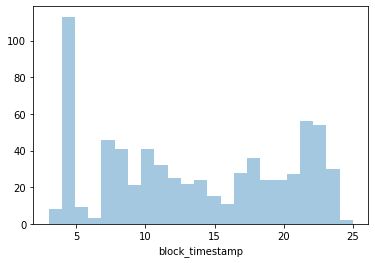

In [117]:
sns.distplot(fei_usdc_data.block_timestamp.dt.day, kde=False,bins=23)

In [3]:
fei_usdc_data.head()

NameError: name 'fei_usdc_data' is not defined

In [132]:
fei_usdc_data['amount0In'] = fei_usdc_data['amount0In'].astype(np.float64) / pow(10,18)
fei_usdc_data['amount0Out'] = fei_usdc_data['amount0Out'].astype(np.float64) / pow(10,18)
fei_usdc_data['amount1In'] = fei_usdc_data['amount1In'].astype(np.float64) / pow(10,6)
fei_usdc_data['amount1Out'] = fei_usdc_data['amount1Out'].astype(np.float64) / pow(10,6)
fei_usdc_data['actual_price_a2b'] = fei_usdc_data['amount1Out'] / fei_usdc_data['amount0In']
fei_usdc_data['actual_price_b2a'] = fei_usdc_data['amount0Out'] / fei_usdc_data['amount1In']

In [131]:
# fei_usdc_data.fillna(0,inplace=True)

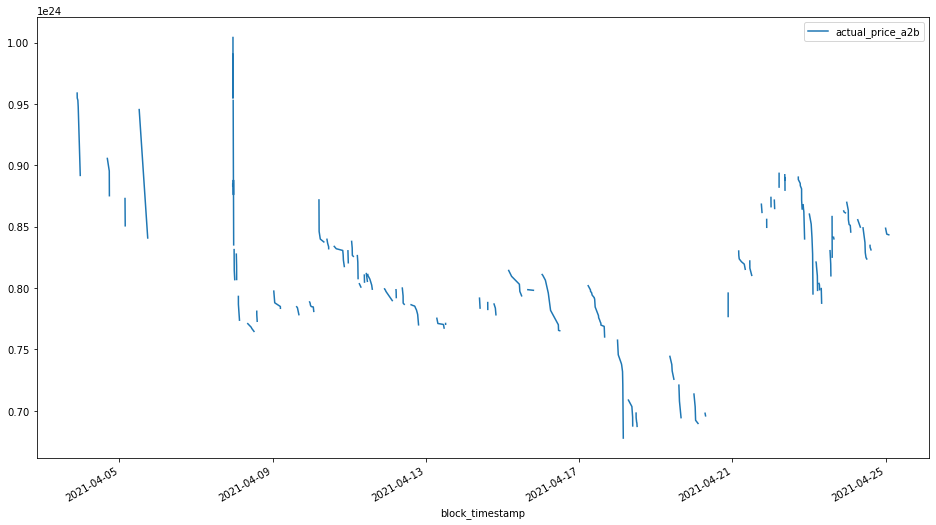

In [148]:
# sns.relplot(x='block_timestamp', y='actual_price_a2b',data=fei_usdc_data)
fig, ax = plt.subplots(1,1,figsize=(16,9))
fei_usdc_data.plot.line(ax=ax, x='block_timestamp', y='actual_price_a2b')

In [150]:
sql = select * from `blockchain-etl.ethereum_uniswap.UniswapV2Pair_event_Sync` where transaction_hash = '0xb8ed1f3626055b26260d05754c3c60d6c47e719fda32a500d159eb8f7ead693d' and block_timestamp > '2021-04-25'
作用是查询当前pool的余额
[
  {
    "block_timestamp": "2021-04-26 07:12:37 UTC",
    "block_number": "12314518",
    "transaction_hash": "0xb8ed1f3626055b26260d05754c3c60d6c47e719fda32a500d159eb8f7ead693d",
    "log_index": "184",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "reserve0": "1271403372143911201149911998",
    "reserve1": "460745907768963837751744"
  }
]
FEI: 1.27B
ETH: 460746
Pair address:0x94b0a3d511b6ecdb17ebf877278ab030acb0a878

SyntaxError: invalid syntax (<ipython-input-150-c32e91b92203>, line 1)

In [154]:
460745907768963837751744 / 1271403372143911201149911998 * 10000

3.6239160431990083

In [151]:
select * from `blockchain-etl.ethereum_uniswap.UniswapV2Pair_event_Mint` where contract_address = '0x94b0a3d511b6ecdb17ebf877278ab030acb0a878'
查询add liquity的操作
{
    "block_timestamp": "2021-04-25 00:48:15 UTC",
    "block_number": "12306263",
    "transaction_hash": "0x64156fda106b6b33b75c4218ee9389b445e784f3b5311ebe11af6e0158c9a5a1",
    "log_index": "243",
    "contract_address": "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
    "sender": "0x7a250d5630b4cf539739df2c5dacb4c659f2488d",
    "amount0": "131609339401944937855",
    "amount1": "49764605551259566"
  },

SyntaxError: invalid syntax (<ipython-input-151-cee06f8eff44>, line 1)

In [2]:
block_timestamp                        2021-04-25 01:44:44 UTC
block_number                                          12306517
log_index                                                   25
contract_address    0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc
sender              0x7a250d5630b4cf539739df2c5dacb4c659f2488d
amount0In                                                    0
amount1In                                             0.990843
amount0Out                                             2210.59
amount1Out                                                   0
to                  0x36314738fce9aca7944d06d18a5fafc7925f26ff
actual_price_a2b                                           NaN
actual_price_b2a                                       2231.02

NameError: name 'fei_usdc_data' is not defined